In [3]:
!unzip /content/Background.zip -d /content/Background

unzip:  cannot find or open /content/Background.zip, /content/Background.zip.zip or /content/Background.zip.ZIP.


In [4]:
!pip install scikit-image

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage import data, color
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from random import sample

In [12]:
import importlib
import constants
importlib.reload(constants)
from constants import (BACKGROUND_PATH)

# Generar Fondos

In [2]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    filename = 'Background/' +str(i)+'.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [3]:
print(len(images))

40


In [4]:
from skimage.transform import rotate, rescale

augmented_images = []

# Parámetros de augmentación
scales = [1.2]      # Ejemplo: zoom in/out
angles = [15, -15, 30]   # Ejemplo: rotaciones

for img in images:
    # Añadir versión escalada sin rotar
    for scale in scales:
        scaled_img = rescale(img, scale, anti_aliasing=True)
        # Asegúrate de volver a ajustar al tamaño deseado si se sale
        scaled_img_resized = resize(scaled_img, (100, 100))
        augmented_images.append(scaled_img_resized)

    # Añadir versión rotada sin escalar
        for angle in angles:
            rotated_img = rotate(scaled_img_resized, angle=angle, resize=False)  # resize=False mantiene el tamaño
            augmented_images.append(rotated_img)

# Mezclar las originales con las nuevas versiones
images.extend(augmented_images)

print(f"Total de imágenes después de la augmentación: {len(images)}")

Total de imágenes después de la augmentación: 200


In [8]:
# import os
# import imageio
# import numpy as np

# fondosPath = 'fondos_pgm'

# # Crear carpeta de salida
# os.makedirs(fondosPath, exist_ok=True)

# # Guardar cada parche como .pgm
# for i, patch in enumerate(images):
#     # Asegurar que cada parche sea 2D y uint8
#     if patch.ndim == 3:
#         patch = patch[:, :, 0]  # Tomar solo un canal si tiene más de uno
#     patch_uint8 = (patch * 255).astype(np.uint8)

#     imageio.imwrite(f"{fondosPath}/{i:04}.pgm", patch_uint8)

IndexError: index 100 is out of bounds for axis 0 with size 100

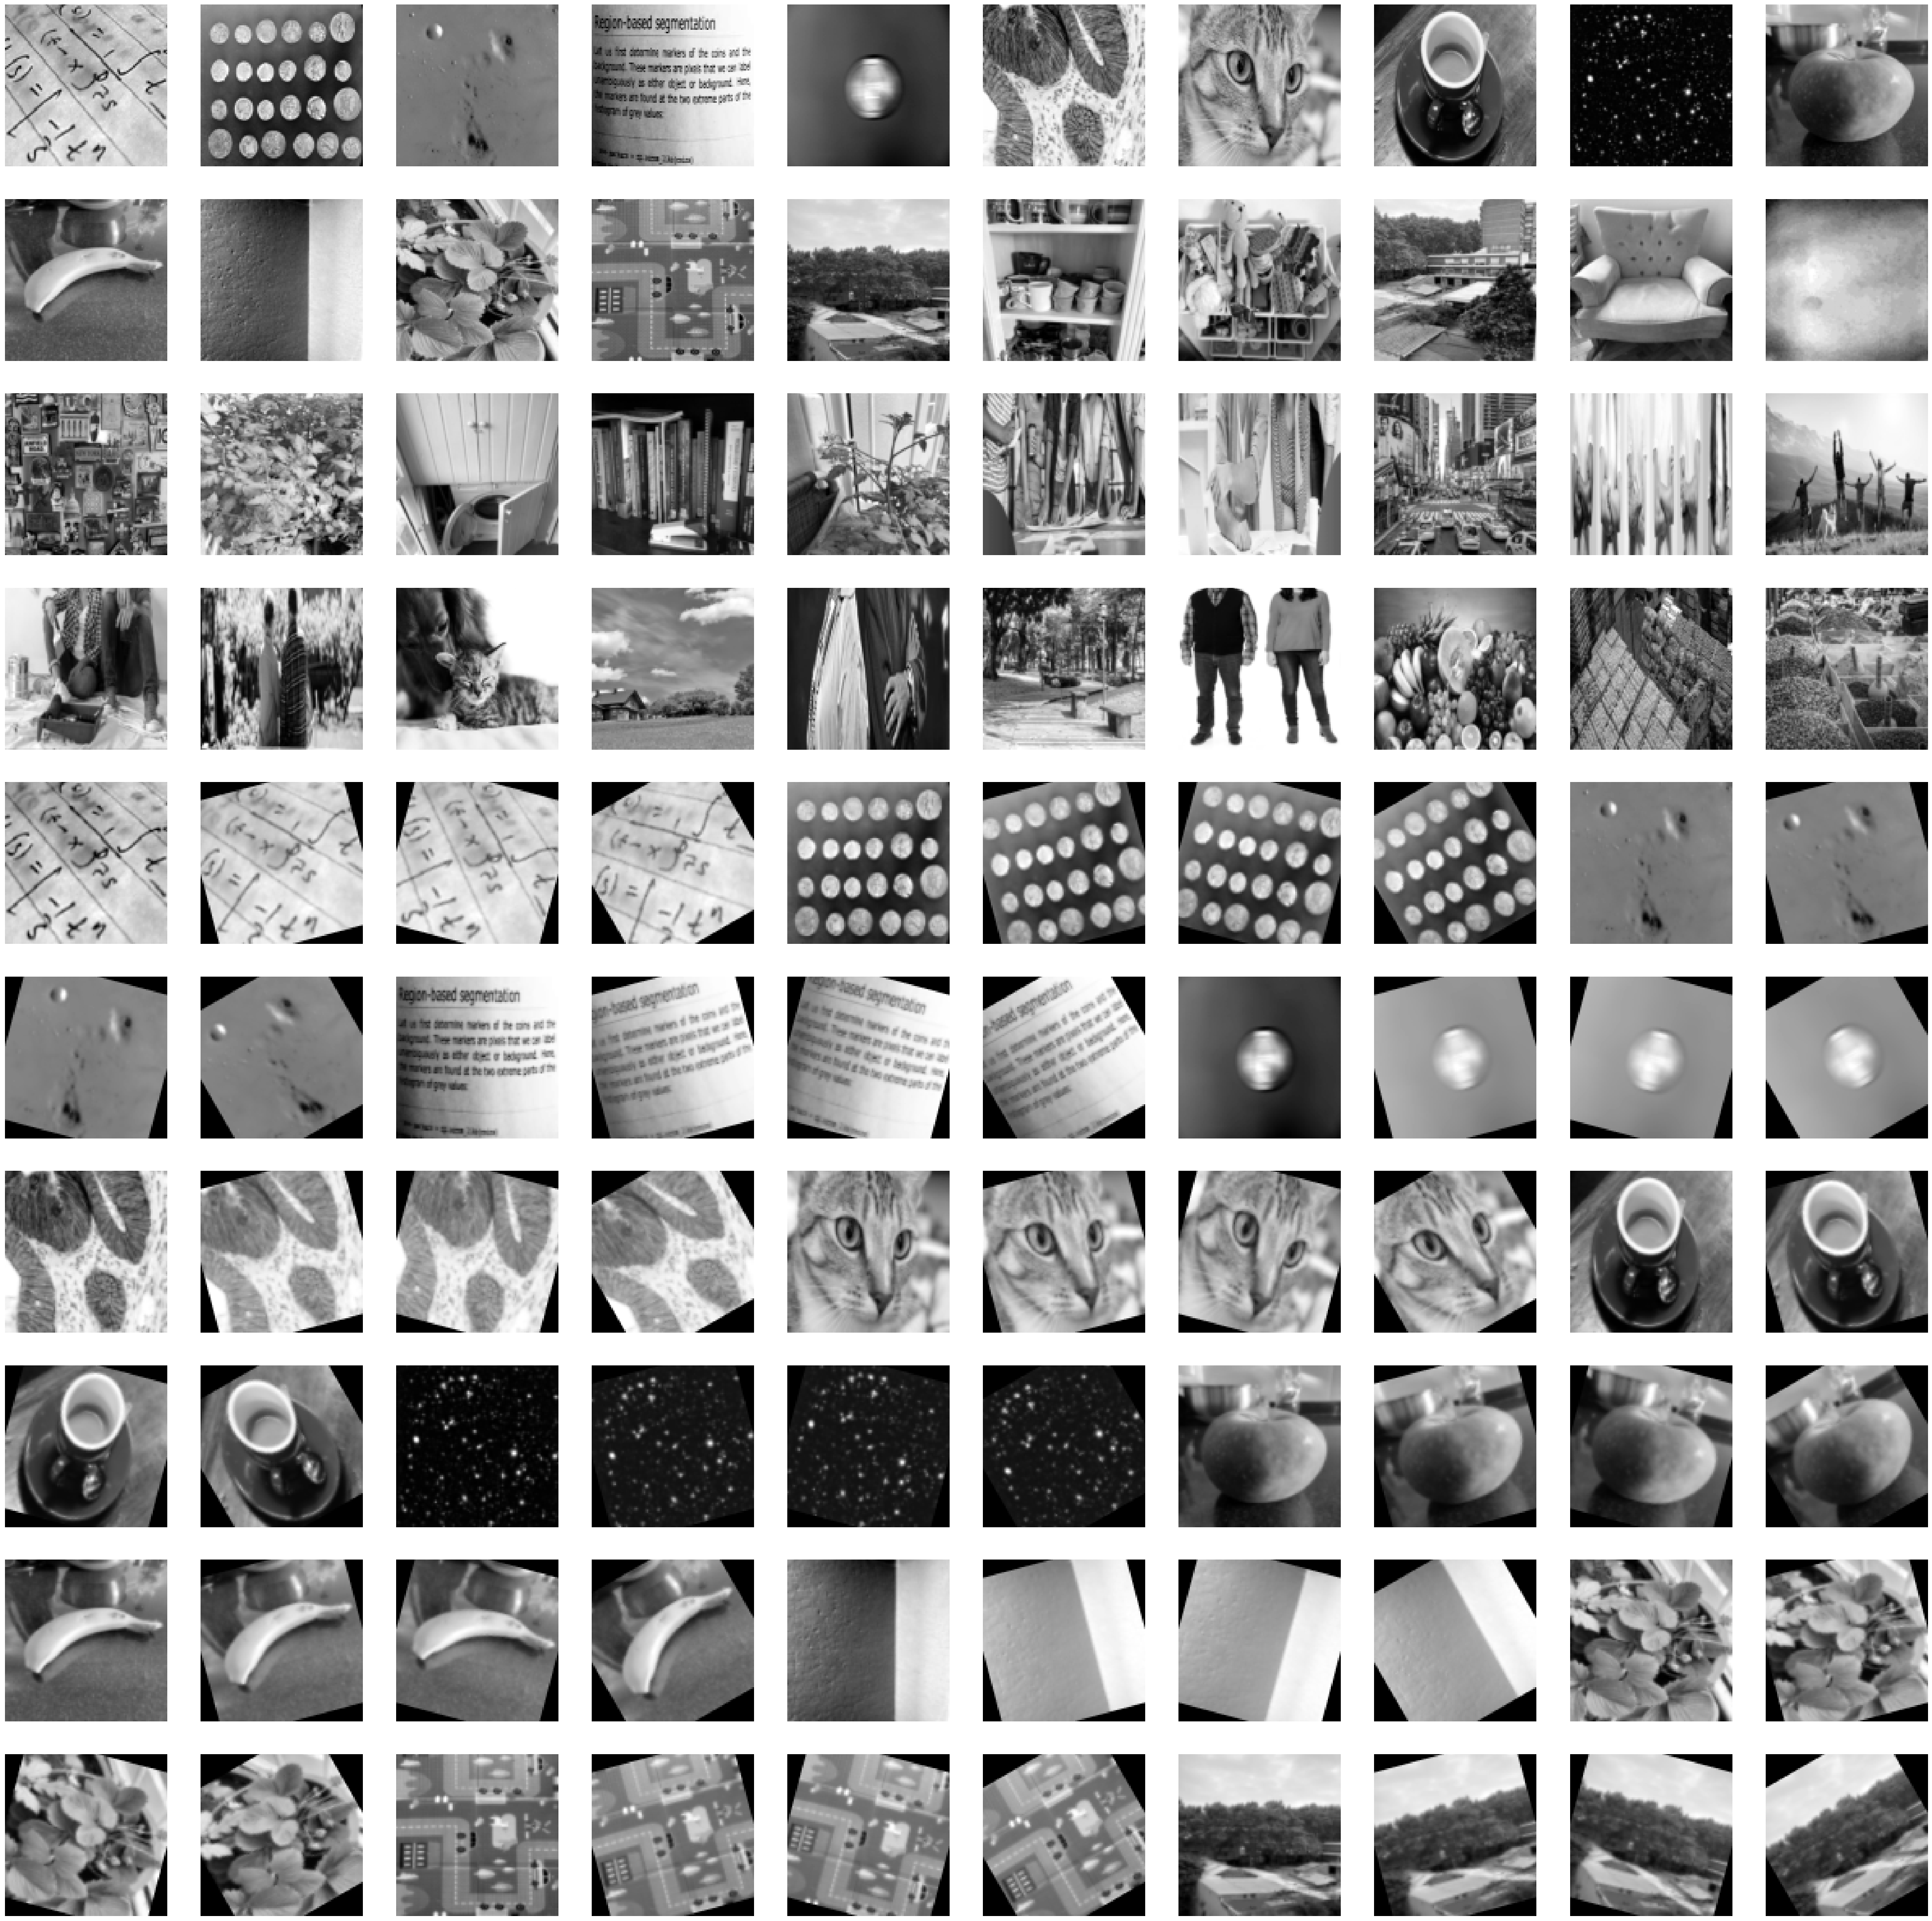

In [6]:
# Visualización
fig, ax = plt.subplots(10, 10, figsize=(50, 50), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(len(images)):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()

In [7]:
# Tamaño de las imágenes de rostros
size = (64, 64)
print(f'Image size: {size}')

Image size: (64, 64)


In [8]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [9]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 200/200 [00:06<00:00, 29.27it/s]


(64000, 64, 64)

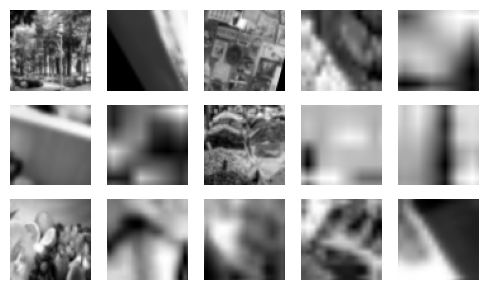

In [10]:
# Visualizamos una muestra
samples = sample(range(negative_patches.shape[0]), 15)
fig, ax = plt.subplots(3, 5, figsize=(5,3))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [13]:
import os
import imageio
import numpy as np


# Crear carpeta de salida
os.makedirs(BACKGROUND_PATH, exist_ok=True)

# Guardar cada parche como .pgm
for i, patch in enumerate(negative_patches):
    # Asegurar que cada parche sea 2D y uint8
    if patch.ndim == 3:
        patch = patch[:, :, 0]  # Tomar solo un canal si tiene más de uno
    patch_uint8 = (patch * 255).astype(np.uint8)

    imageio.imwrite(f"{BACKGROUND_PATH}/b_{i:04}.pgm", patch_uint8)
